**Setting up the notebook:**

Installing Google Drive to save the main milestones.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

We install the following library to visualize the Geocoding of Chicago with its main road segments. The goal is to extract a complete picture of Chicago with its main roads: highways, freeways, primary streets.

In [0]:
!pip install geopandas

# **I - Create an image with the Chicago main regions**

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

We extract the GeoJson main road networks from https://overpass-turbo.eu

The main road network is composed of highways, primary streets and trunks (regional highways). 

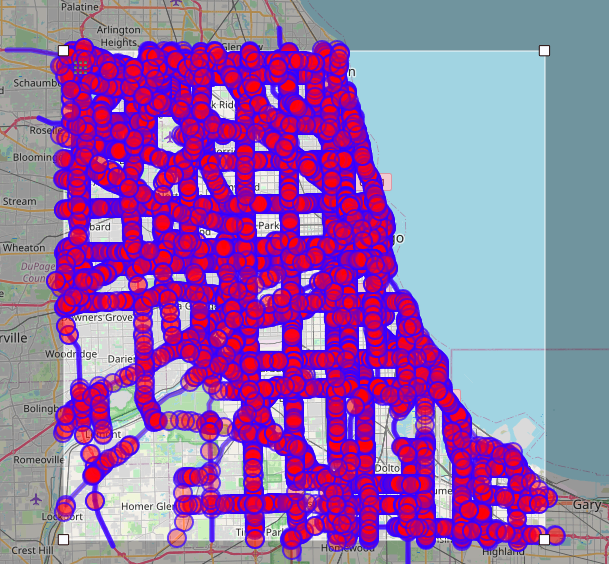

In [0]:
from IPython.display import Image
Image(filename='/content/chicago main road network.png') 

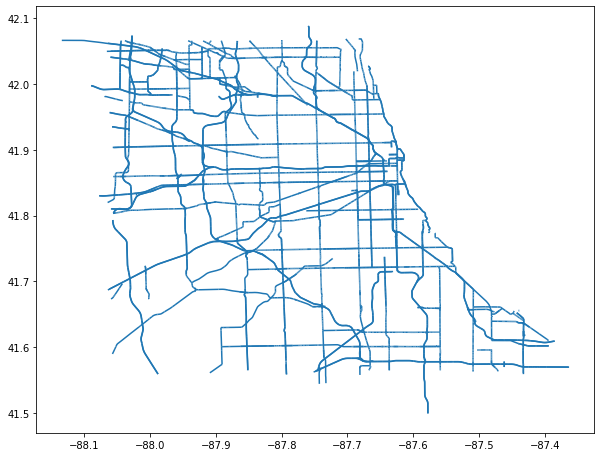

In [0]:
streetmap = gpd.read_file('/content/chicago_road_network.geojson')
fig, ax = plt.subplots( figsize = (10, 10) )
streetmap.plot(ax = ax)

We save the image above and then crop it to remove the regions not part of Chicago.

We transform the picture into binary (black and white) image.

In [0]:
import cv2

img_grey = cv2.imread('/content/chicago_road_network_image.png', cv2.IMREAD_GRAYSCALE)
# define a threshold, 128 is the middle of black and white in grey scale
thresh = 250
# threshold the image
img_binary = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)[1]
#save image
cv2.imwrite('/content/chicago_road_network_image_binary.png',img_binary) 

True

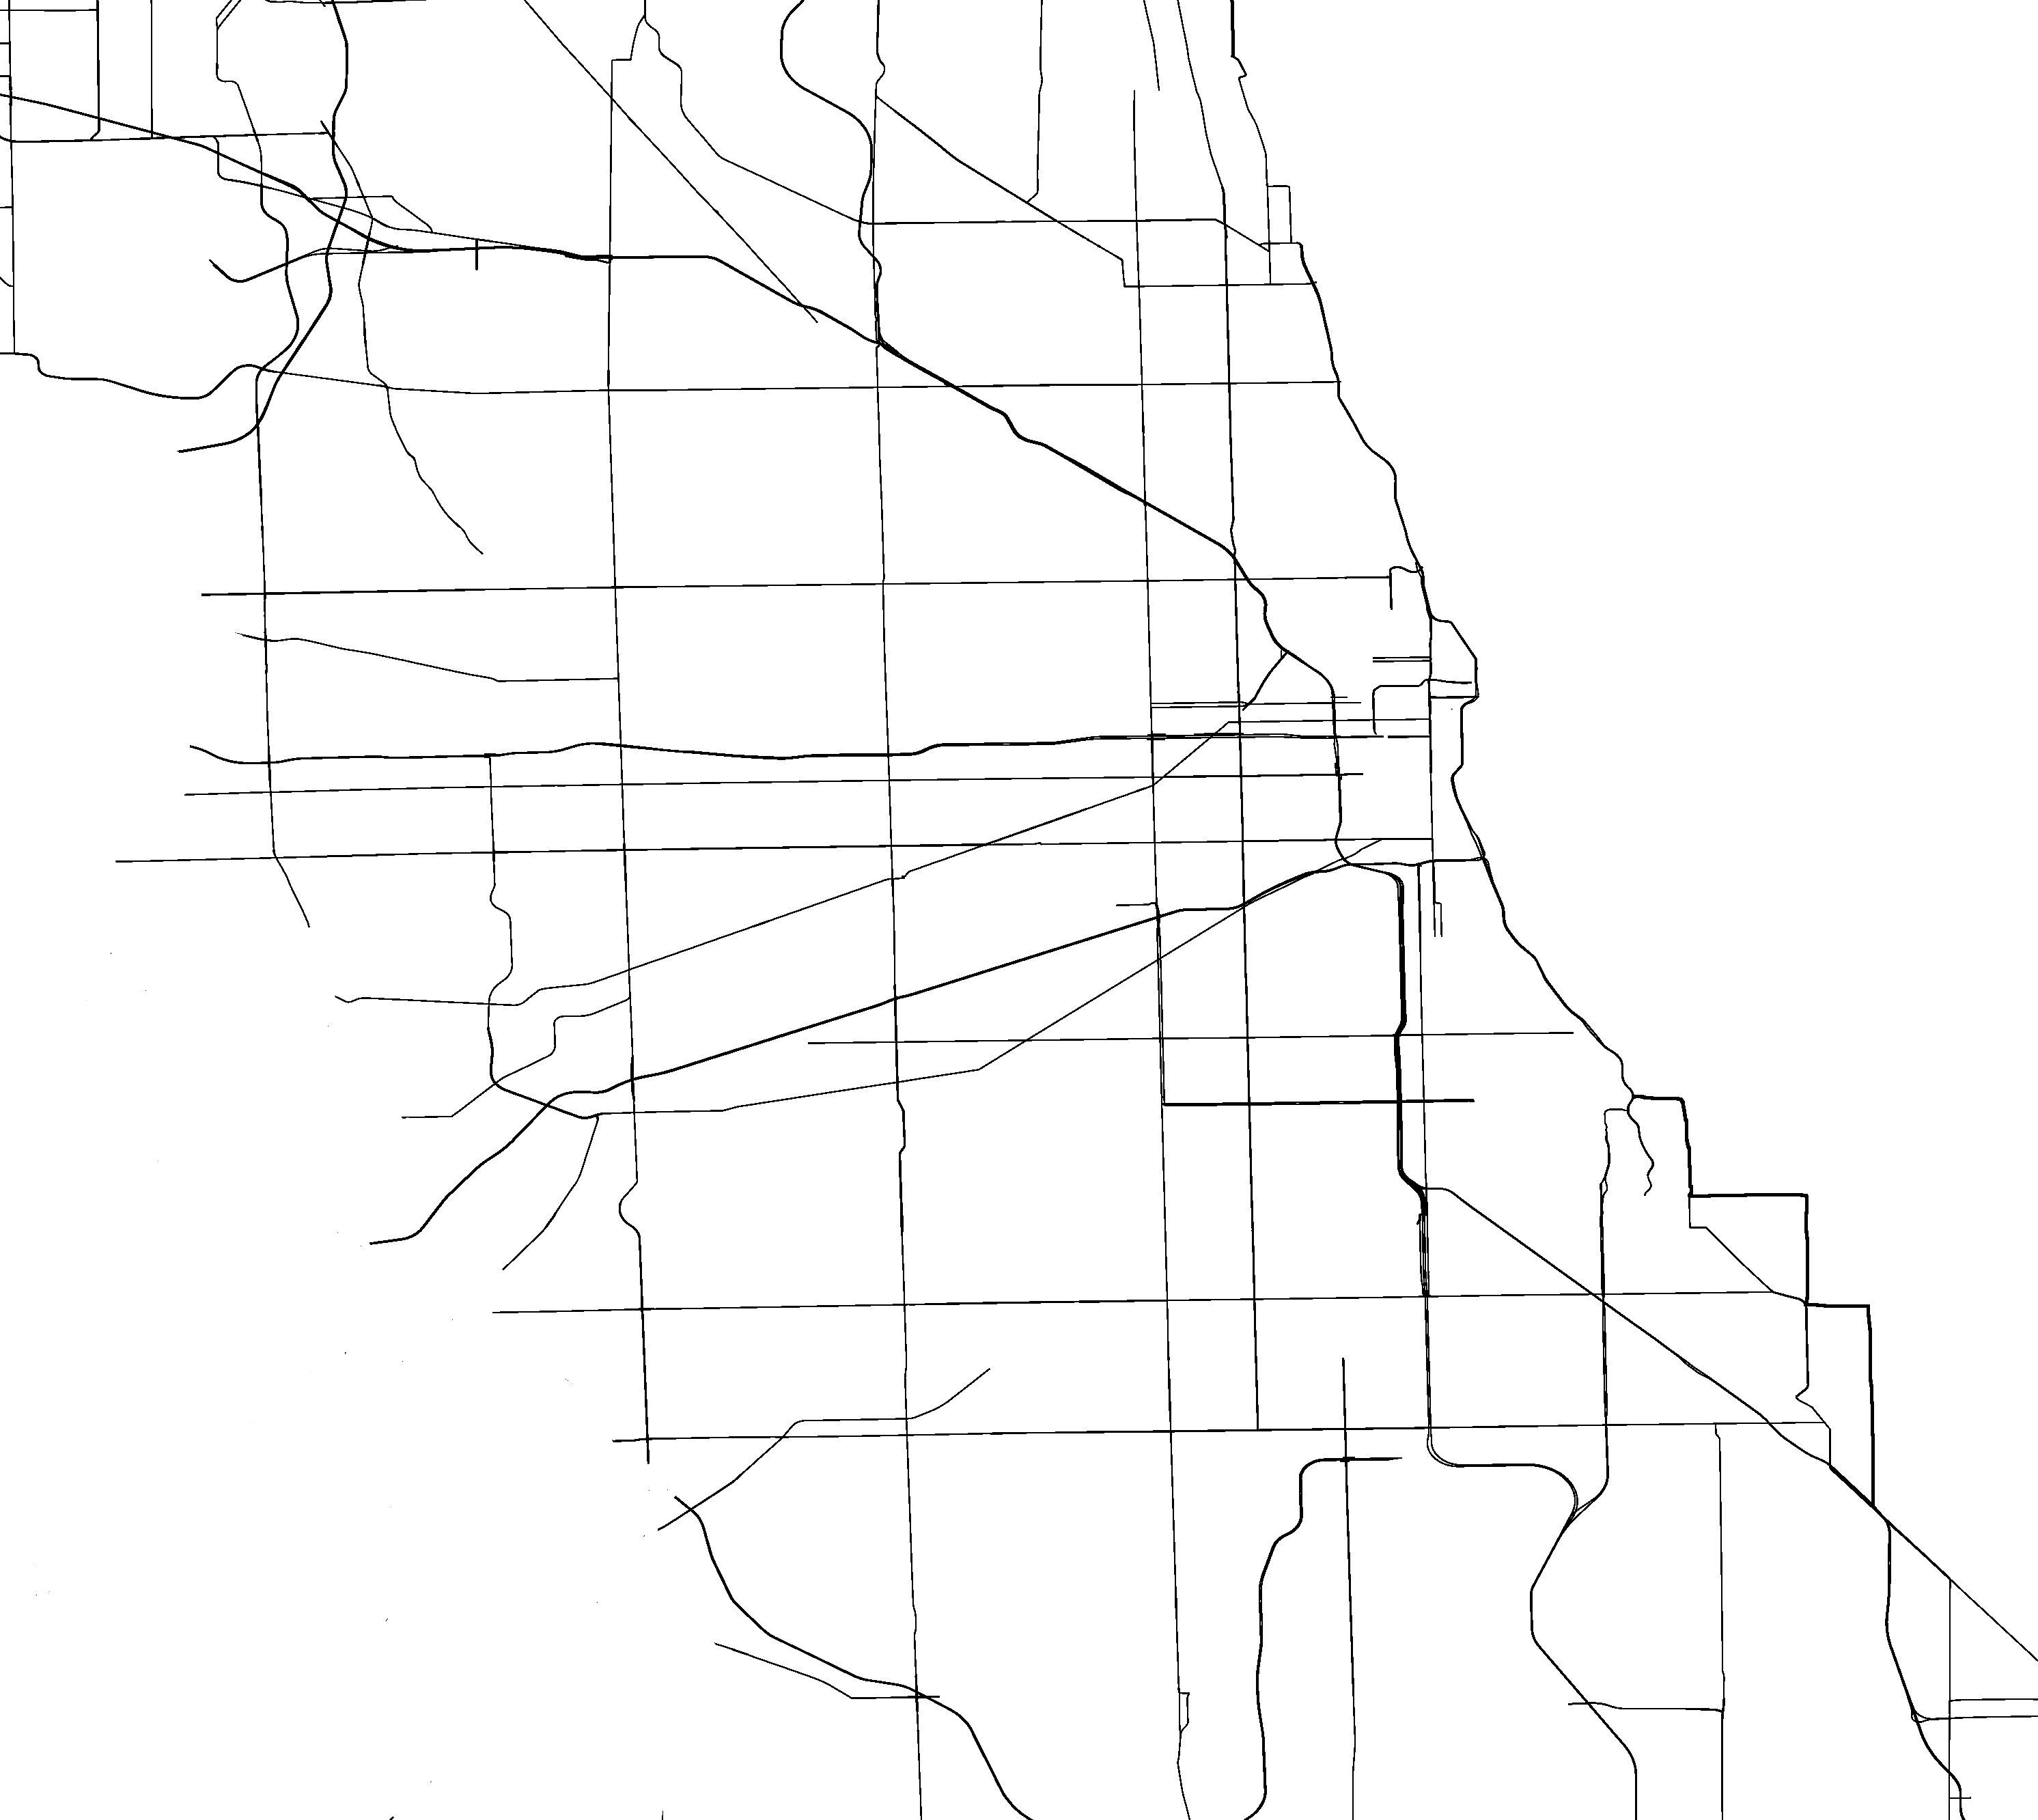

In [0]:
from IPython.display import Image
Image(filename='/content/chicago_road_network_image_binary_retouched.png')

Now, we perform the dilation of the road network. The goal is to merge highways/streets, with various lanes, into single segments.

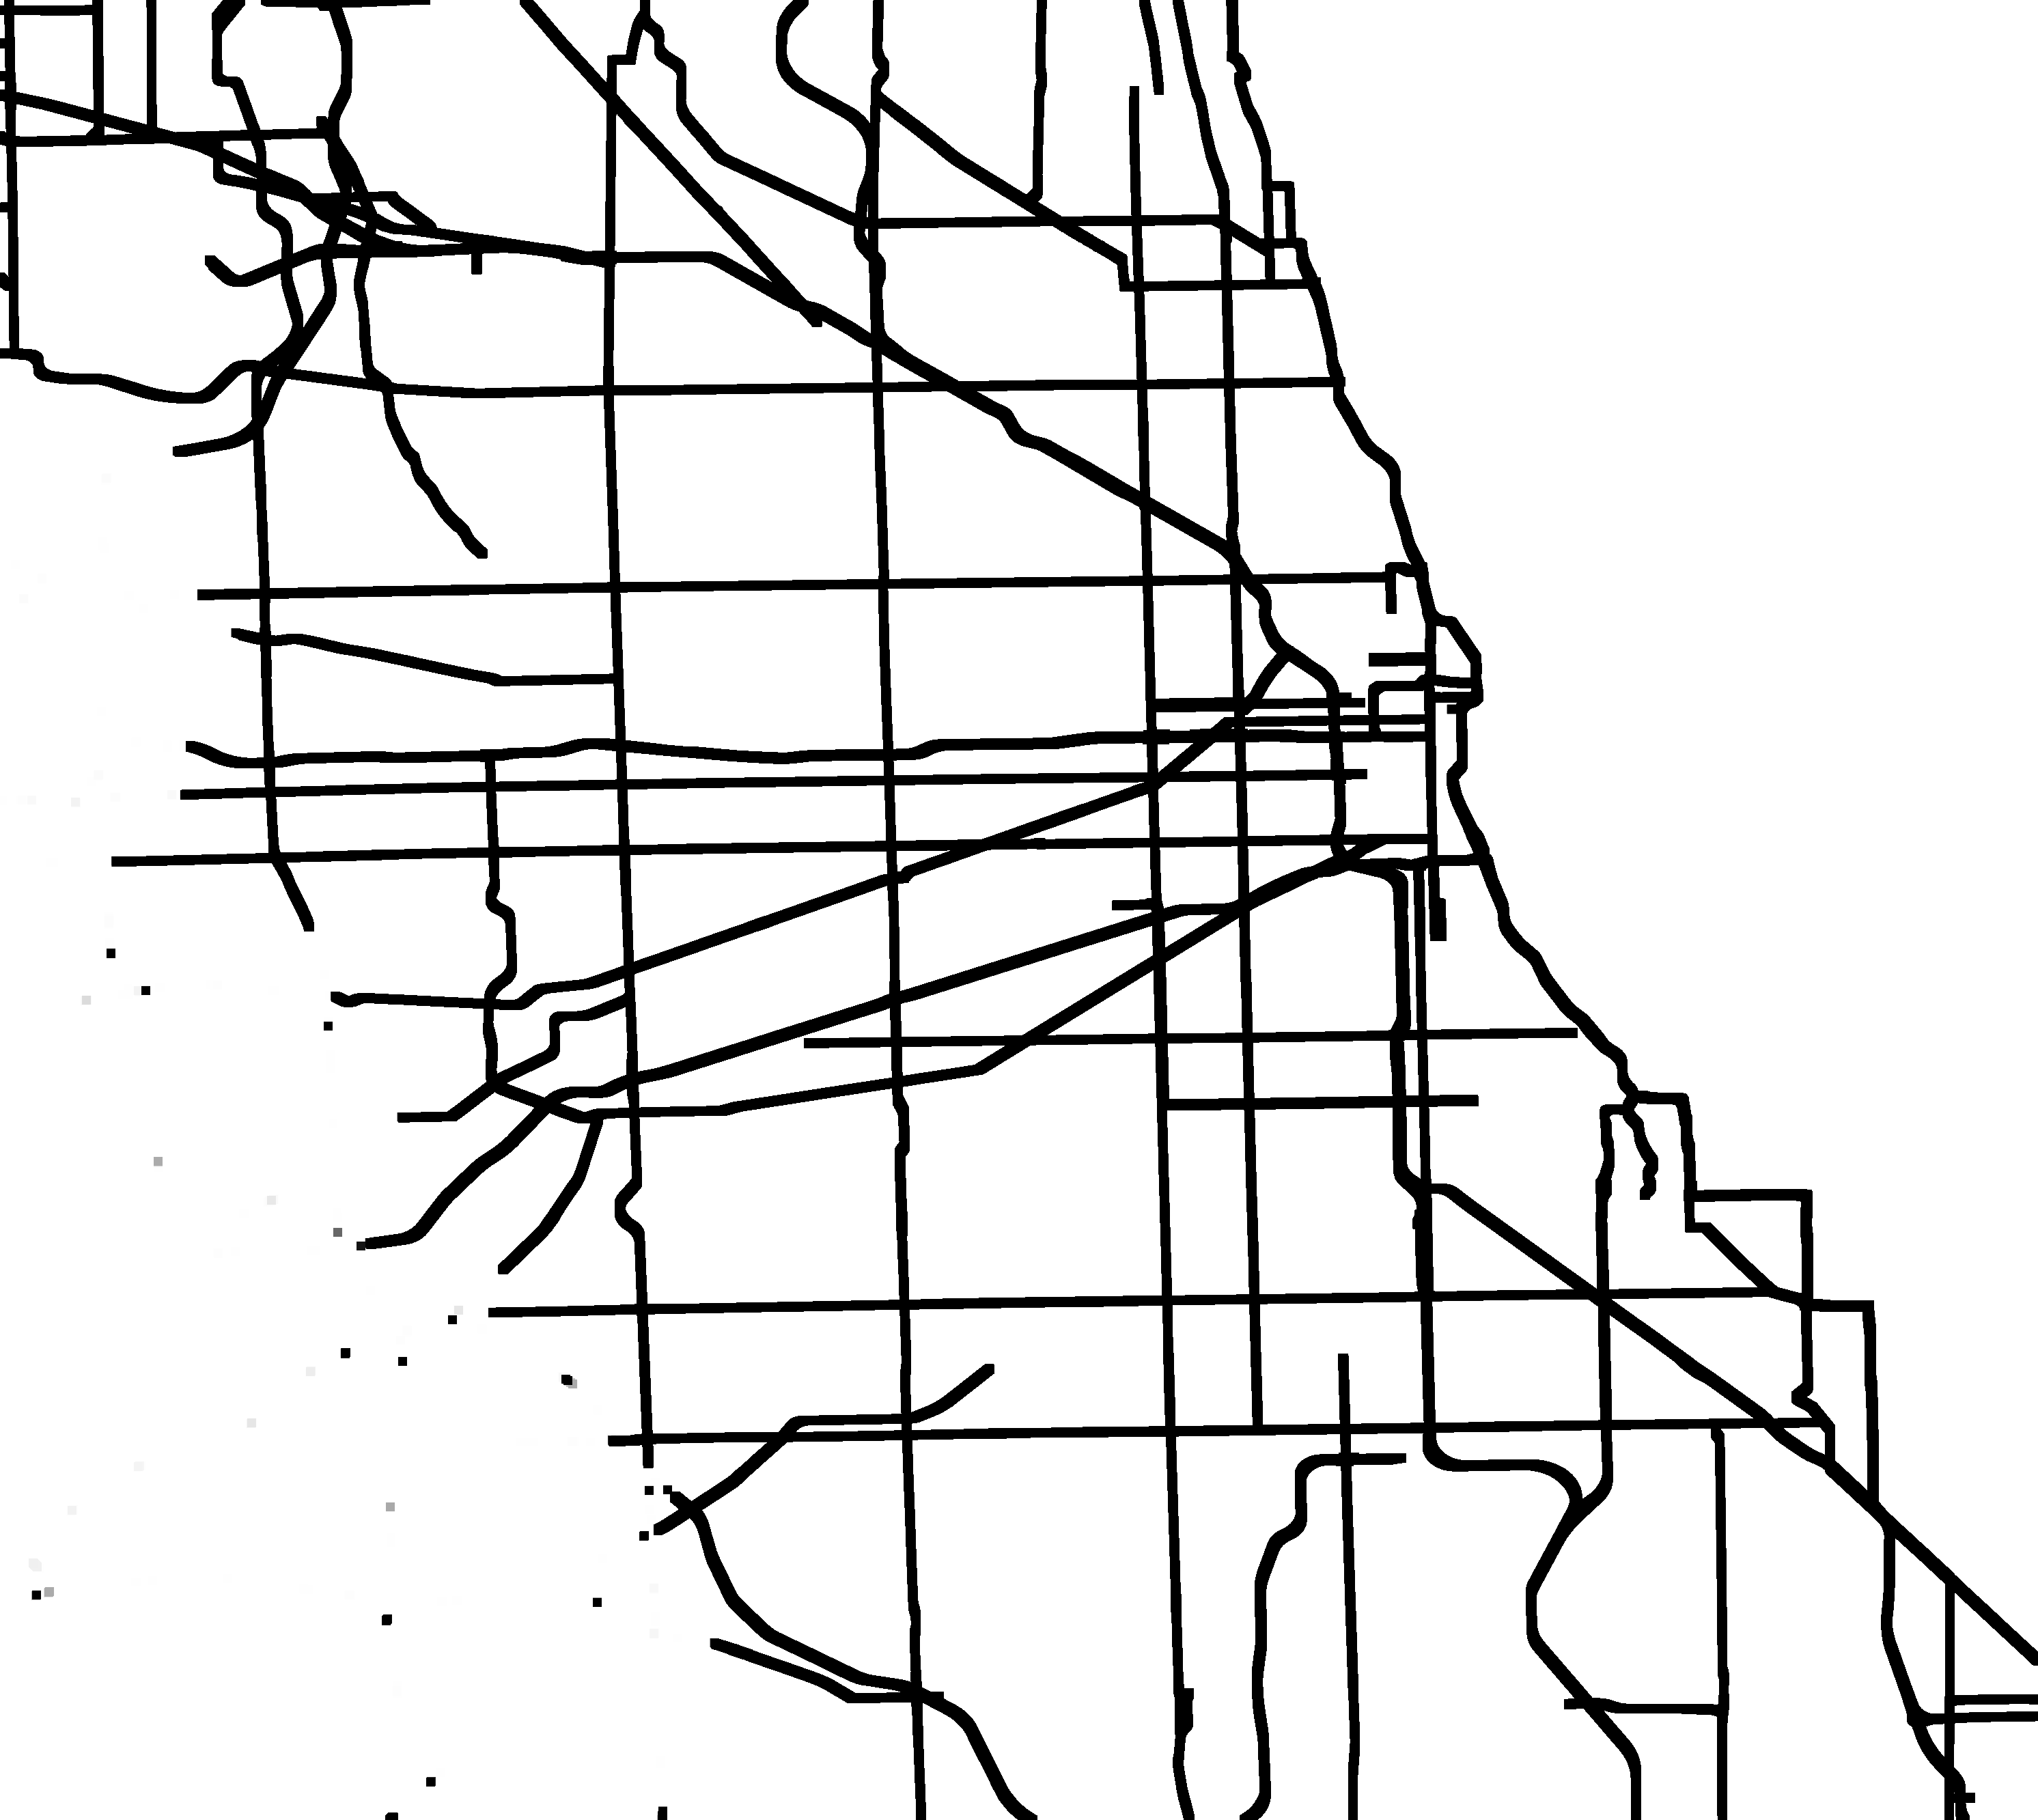

-1

In [0]:
# Python program to demonstrate erosion and  
# dilation of images. 
import cv2 
import numpy as np 
  
# Reading the input image 
img = cv2.imread('/content/chicago_road_network_image_binary_retouched.png', 0) 
  
# Taking a matrix of size 5 as the kernel 
kernel = np.ones((5,5), np.uint8) 
  
# The first parameter is the original image, 
# kernel is the matrix with which image is  
# convolved and third parameter is the number  
# of iterations, which will determine how much  
# you want to erode/dilate a given image.  
img_erosion = cv2.erode(img, kernel, iterations=3) 

from google.colab.patches import cv2_imshow
cv2_imshow(img_erosion)

cv2.waitKey(0) 

**In the images below, we selected a local region of the map above to see the dilation more clearly.**

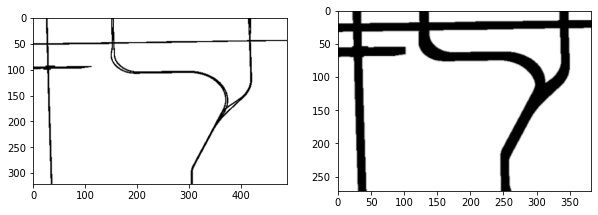

In [0]:
local_image_bef = cv2.imread("/content/local_view_before_dilation.png")
local_image_aft = cv2.imread("/content/local_view_after_dilation.png")
fig, axes = plt.subplots(1,2, figsize=(10, 10))
axes[0].imshow(local_image_bef)
axes[1].imshow(local_image_aft)

In [0]:
cv2.imwrite('chicago_road_network_dilated.png',img_erosion) 

In [0]:
!cp '/content/chicago_road_network_dilated.png'  '/content/gdrive/My Drive/urban-computing-project/chicago_road_network_dilated.png'

**Thinning process using Zhang-Suen thinning implementation:**


After the dilation of the road network, we perform a thinnning process of the road segments. The goal is to be able to map GPS coordinates inside one region, delimited by road segments, and preventing them from falling onto a road segment.

In [0]:
image = cv2.imread("chicago_road_network_dilated_inverted.png")
thinned_image = cv2.ximgproc.thinning(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))

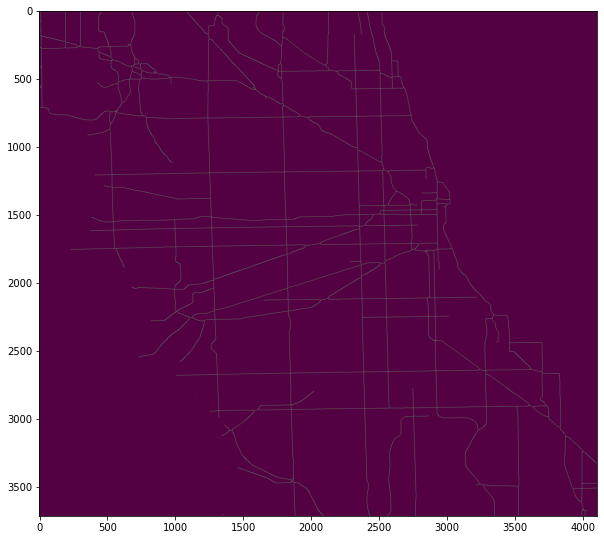

In [0]:
image_thinned = cv2.imread("chicago_road_network_thinned.png")
fig, axes = plt.subplots(figsize=(10, 10))
axes.imshow(image_thinned)

In [0]:
import cv2

image = cv2.imread('/content/chicago_road_network_thinned.png')
inverted = cv2.bitwise_not(image)

cv2.imwrite('chicago_road_network_thinned_inverted.png',inverted) 

We transform the image into black and white, with the road network appearing in black.

In [0]:
from PIL import Image
img = Image.open('chicago_road_network_thinned_inverted.png')
thresh = 200
fn = lambda x : 255 if x > thresh else 0
r = img.convert('L').point(fn, mode='1')
r.save('chicago_road_network_thinned_inverted_2.png')

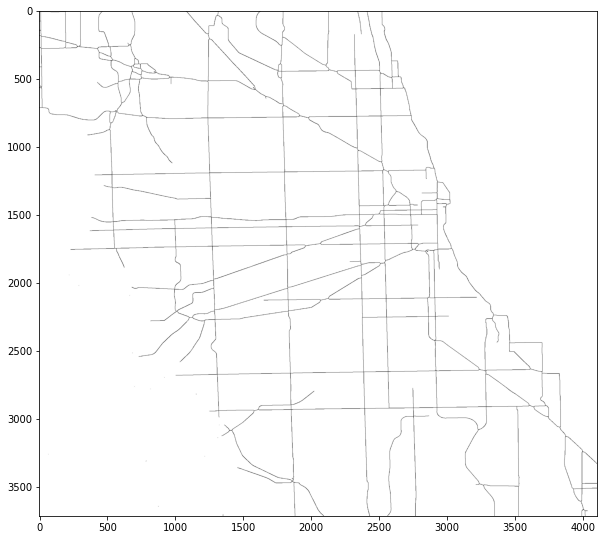

In [0]:
image_thinned_binnary = cv2.imread("chicago_road_network_thinned_inverted_2.png")
fig, axes = plt.subplots(figsize=(10, 10))
axes.imshow(image_thinned_binnary)

**If we look at the local view selected before, we get the following results:**

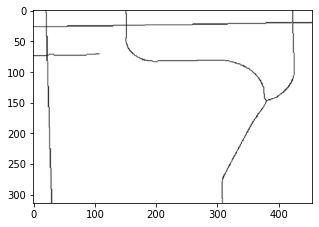

In [0]:
local_view_thinned = cv2.imread("/content/local_view_thinned.png")
fig, axes = plt.subplots(figsize=(5, 5))
axes.imshow(local_view_thinned)

We save the image in the GDrive to keep a copy.

In [0]:
!cp '/content/chicago_road_network_thinned_inverted_2.png'  '/content/gdrive/My Drive/urban-computing-project/chicago_road_network_thinned_inverted_2.png'

# **Labeling of each area delimited by roads**

Now, we are ready to label each region, inside the road network, on the thinned image. Each labeled area will also have a unique ID. That way, for any given GPS coordinates, we can map them to a unique ID.

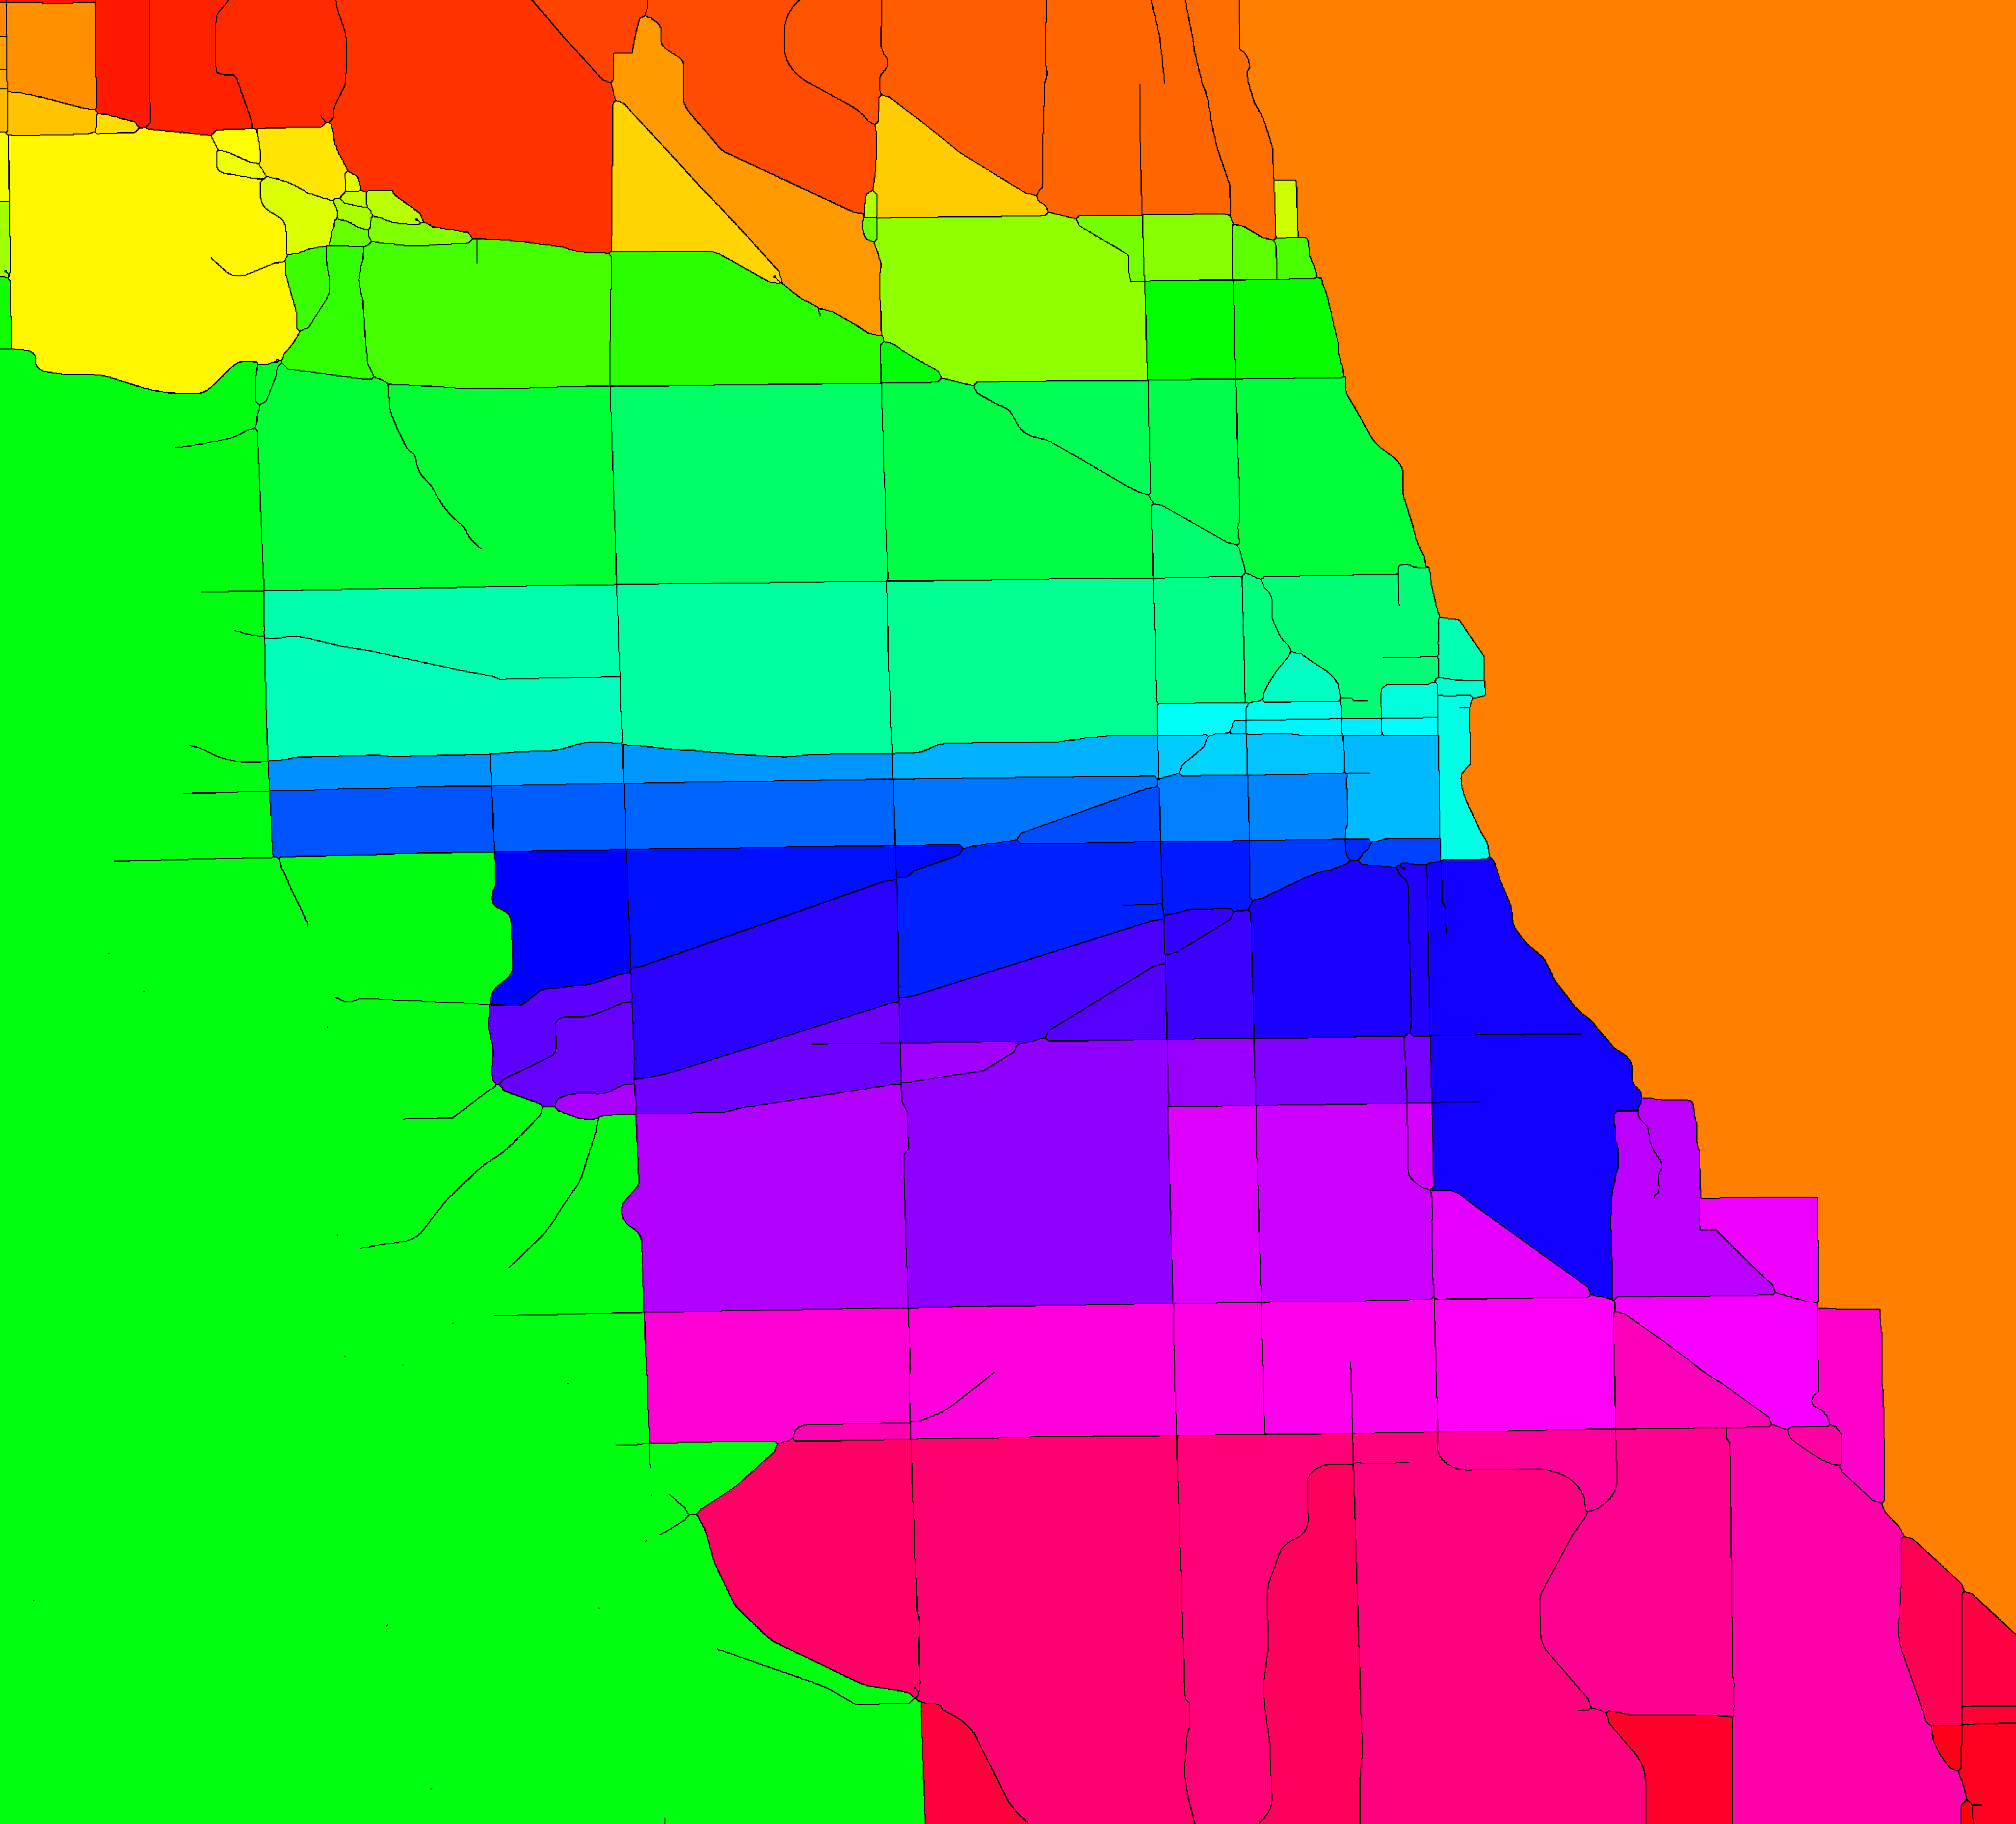

In [0]:
import cv2
import numpy as np

img = cv2.imread('chicago_road_network_thinned_inverted_2.png', 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
num_labels, labels_im = cv2.connectedComponents(img)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    from google.colab.patches import cv2_imshow
    cv2_imshow(labeled_img)
    cv2.imwrite('chicago_road_network_labeled.png',labeled_img) 

imshow_components(labels_im)

In [0]:
print("Number of labels ", num_labels)

Number of labels  155


**For the local view, we get the following labeling:**

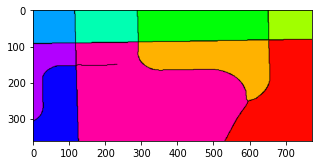

In [9]:
import matplotlib.pyplot as plt
local_view_thinned = cv2.imread("/content/local_view_labeled.png")
fig, axes = plt.subplots(figsize=(5, 5))
axes.imshow(local_view_thinned)

# **Conclusion**

We ended the work about segmenting Chicago into areas with semanting meaning. There ar 155 regions in total. We can then cluster the regions according to similar new-end flows from 3 months of taxi trips. 

# **Sources**



1.   https://overpass-turbo.eu/
2.   cv2: https://pypi.org/project/opencv-python/

